## 2-1. 프로젝트 : 폐렴 진단기 성능개선

조금 전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀 더 분발해야겠죠?

그렇다면 우리는 조금 전까지의 실습 과정을 되짚어보면서, 어떤 점을 더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 더 성능을 향상시켜 보려고 합니다.

우선 주요 라이브러리 버전을 확인해 봅시다.

In [2]:
import tensorflow

print(tensorflow.__version__)

2.6.0


### Step 1. 실험환경 Set-up

거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [3]:
# 패키지 import
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


### Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(TRAIN_IMG_COUNT, len(train_ds), VAL_IMG_COUNT, len(val_ds))

4185 4185 1047 1047


In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [16]:
# augmnet를 적용한 데이터를 위한 함수를 준비합니다.
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# augment를 적용한 데이터를 준비합니다.
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [55]:
# augment를 적용하지 않은 데이터를 위한 함수를 준비합니다.
def prepare_for_training_no_aug(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# augment를 적용하지 않은 데이터를 준비합니다.
train_ds_no_aug = prepare_for_training_no_aug(
    train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
)

val_ds_no_aug = prepare_for_training_no_aug(
    val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
)

In [57]:
# evaluate를 위한 데이터 셋
def prepare_for_evaluation(ds):
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# 평가를 위한 테스트 데이터셋 준비
test_ds_no_aug = prepare_for_evaluation(test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE))

### Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

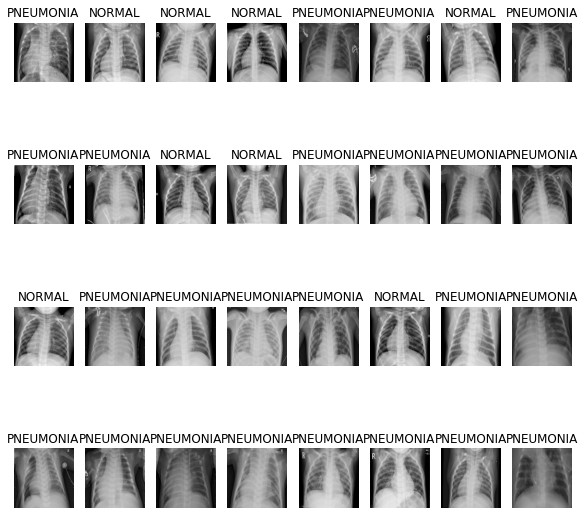

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. ResNet-18 구현
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

이번 스텝에서는 ResNet-18 구현을 진행합니다. ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다.

ResNet의 특징이라면 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점입니다. ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있습니다.

우리는 ResNet의 가장 작은 버전인 ResNet-18로 구현하려고 합니다.

ResNet은 Residual block을 먼저 구성해야 합니다. ResNet에서의 weight layer는

1. 3x3 CNN
2. BatchNormalization
3. 활성화 함수 ReLU 로 구성되어 있습니다.

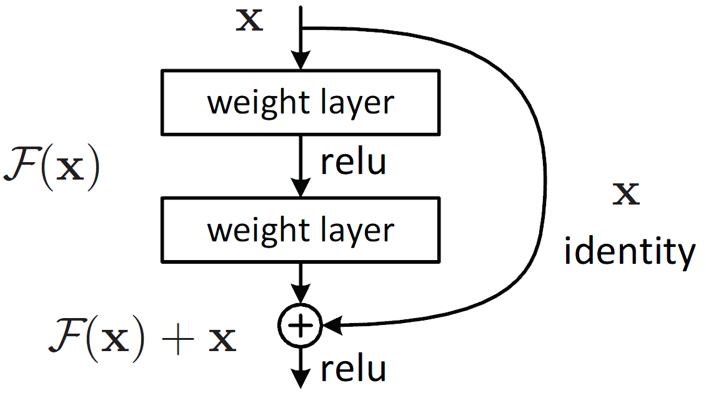
Residual Connection ([출처](https://paperswithcode.com/method/residual-block))

위에 있는 그림대로 Residual block을 구성했다면 이제는 아래 그림을 보고 ResNet을 구현해주세요 (참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔주세요!)

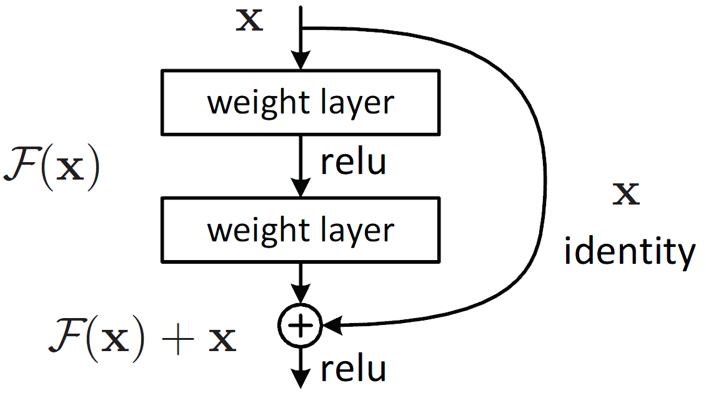
[ResNet-18 모델 (출처 : ResNet Paper)]

In [40]:
# Convolution Block 정의
def conv_block(filters):
    # 이 함수는 컨볼루션 블록을 만들고, 이는 2개의 컨볼루션 레이어와 배치 정규화, 맥스 풀링을 포함합니다.
    # filters: 컨볼루션 레이어에 사용될 필터(뉴런)의 수
    block = tf.keras.Sequential([
        layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D()
    ])
    return block

# Dense Block 정의
def dense_block(units, dropout_rate):
    # 이 함수는 밀집(dense) 블록을 만들고, 이는 밀집 레이어, 배치 정규화, 드롭아웃을 포함합니다.
    # units: 밀집 레이어에 사용될 뉴런의 수
    # dropout_rate: 드롭아웃 비율 (예: 0.3은 30% 뉴런을 무작위로 끄는 것을 의미)
    block = tf.keras.Sequential([
        layers.Dense(units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate)
    ])
    return block

In [41]:
# 레이어를 간편하게 구성하기 위해 다시한번 import
import tensorflow as tf
from tensorflow.keras import layers, models

# CNN 모델 구축
def build_cnn_model(input_shape, num_classes):
   
    model = models.Sequential([
        
        layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        
        layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        layers.Dropout(0.2),
        
        conv_block(256),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, conv_num=3, activation="relu", kernel_size=(3, 3), strides=1):
    # Shortcut 경로 설정: 이 블록의 입력을 나중에 더하기 위해 저장합니다.
    shortcut = x
    # 필터의 수나 스트라이드가 달라 입력과 출력의 차원이 맞지 않을 경우 1x1 컨볼루션으로 차원을 조정합니다.
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides)(x)
        shortcut = layers.BatchNormalization()(shortcut)

    # Main Path: 본격적인 컨볼루션 연산을 수행하는 경로입니다.
    for i in range(conv_num):
        # 컨볼루션 레이어: 이미지에서 특징을 추출합니다. 'filters'는 필터의 수, 'kernel_size'는 필터의 크기를 의미합니다.
        x = layers.Conv2D(filters, kernel_size, padding='same', strides=strides if i == 0 else 1)(x)
        # 배치 정규화: 네트워크가 더 잘 학습하도록 도와줍니다.
        x = layers.BatchNormalization()(x)
        # 활성화 함수: 비선형성을 추가해줍니다. 여기서는 'relu'가 사용됩니다.
        x = layers.Activation(activation)(x)

    # Shortcut과 Main Path의 결과를 합쳐줍니다.
    x = layers.add([shortcut, x])
    return x

In [43]:
def build_resnet18(input_shape, num_classes):
    # 모델의 입력을 정의합니다. 'input_shape'는 입력 이미지의 크기입니다.
    inputs = tf.keras.Input(shape=input_shape)

    # 초기 컨볼루션 레이어: 모델의 첫 번째 레이어로, 큰 특징을 추출합니다.
    x = layers.Conv2D(64, (7, 7), strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding="same")(x)

    # Residual Blocks: 각 블록은 이미지의 특징을 더 세밀하게 추출합니다.
    x = residual_block(x, 64, conv_num=2, strides=1)
    x = residual_block(x, 128, conv_num=2, strides=2)
    x = residual_block(x, 256, conv_num=2, strides=2)
    x = residual_block(x, 512, conv_num=2, strides=2)

    # Classifier: 모델의 마지막 부분으로, 추출된 특징을 기반으로 이미지를 분류합니다.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation="softmax")(x)

    # 모델을 생성합니다. 이때 'inputs'는 입력층, 'x'는 출력층을 나타냅니다.
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [44]:
# CNN 모델 파라미터 설정
cnn_input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3) # 여기서 IMAGE_SIZE는 이미지의 크기를 정의한 변수입니다.
cnn_num_classes = 1  # 폐렴을 진단하는 경우, 클래스는 '정상'과 '폐렴' 두 가지가 됩니다.

# CNN 모델 구축 및 요약
cnn_model = build_cnn_model(cnn_input_shape, cnn_num_classes)
cnn_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_16 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_17 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_18 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_10 (Dropout)         (None, 11, 11, 128)     

In [45]:
# 모델 파라미터 설정: 'input_shape'는 입력 이미지의 크기, 'num_classes'는 분류할 클래스의 수입니다.
res_input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)  # 예를 들어, ImageNet 데이터셋의 표준 입력 크기
res_num_classes = 1  # 폐렴을 진단하는 경우, 클래스는 '정상'과 '폐렴' 두 가지가 됩니다.

# 모델을 구축하고, 구조를 출력합니다.
res_model = build_resnet18(res_input_shape, res_num_classes)
res_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 90, 90, 64)   9472        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 90, 90, 64)   256         conv2d_54[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 90, 90, 64)   0           batch_normalization_69[0][0]     
____________________________________________________________________________________________

### Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [46]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [47]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# GPU 설정
with tf.device('/GPU:0'):
    # CNN 모델 컴파일
    cnn_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

    # ResNet 모델 컴파일
    res_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

In [48]:
# 모델 훈련을 위한 파라미터
# EPOCHS = 10  # 에포크 수
# BATCH_SIZE = 32  # 배치 크기
# TRAIN_IMG_COUNT = len(train_ds)  # 훈련 이미지 수
# VAL_IMG_COUNT = len(val_ds)  # 검증 이미지 수

# CNN 모델 훈련
with tf.device('/GPU:0'):
    history_cnn = cnn_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/20
130/130 [==============================] - 61s 397ms/step - loss: 0.4134 - accuracy: 0.7865 - precision: 0.9532 - recall: 0.7498 - val_loss: 0.5982 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 51s 391ms/step - loss: 0.2411 - accuracy: 0.9077 - precision: 0.9709 - recall: 0.9032 - val_loss: 0.7832 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 51s 394ms/step - loss: 0.1779 - accuracy: 0.9382 - precision: 0.9800 - recall: 0.9360 - val_loss: 0.9919 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 52s 401ms/step - loss: 0.1527 - accuracy: 0.9464 - precision: 0.9852 - recall: 0.9423 - val_loss: 1.2757 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 53s 411ms/step - loss: 0.1458 - accura

In [49]:
# ResNet 모델 훈련
with tf.device('/GPU:0'):
    history_resnet = res_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/20
130/130 [==============================] - 60s 382ms/step - loss: 0.2479 - accuracy: 0.7450 - precision: 0.7450 - recall: 1.0000 - val_loss: 8.5425 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 49s 382ms/step - loss: 0.1513 - accuracy: 0.7430 - precision: 0.7430 - recall: 1.0000 - val_loss: 3.8588 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 51s 393ms/step - loss: 0.1234 - accuracy: 0.7454 - precision: 0.7454 - recall: 1.0000 - val_loss: 0.1821 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 53s 412ms/step - loss: 0.1065 - accuracy: 0.7430 - precision: 0.7430 - recall: 1.0000 - val_loss: 1.9109 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 55s 424ms/step - loss: 0.0962 - accura

### Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

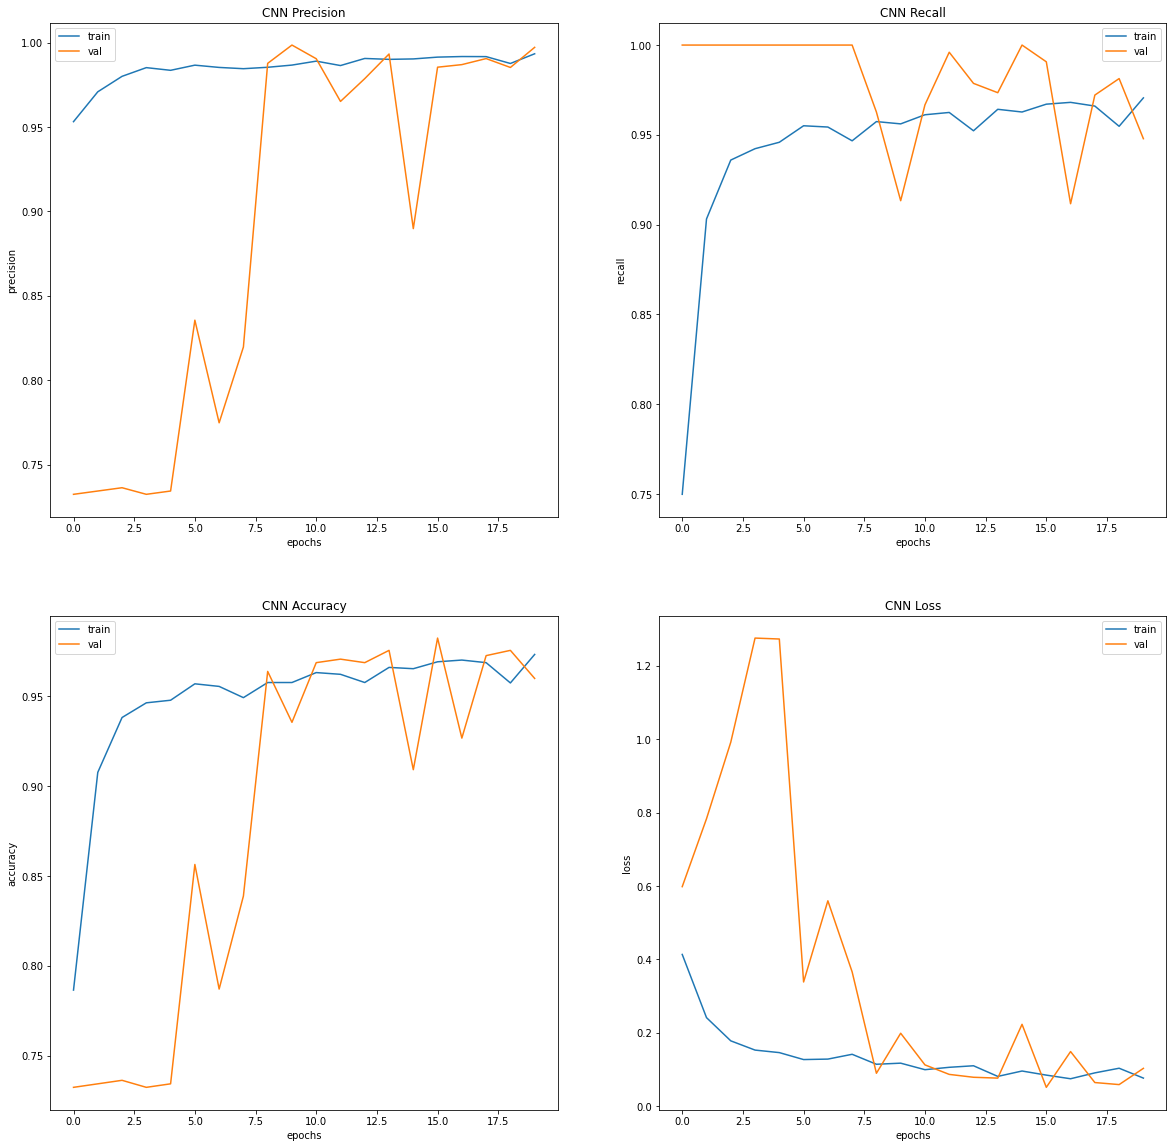

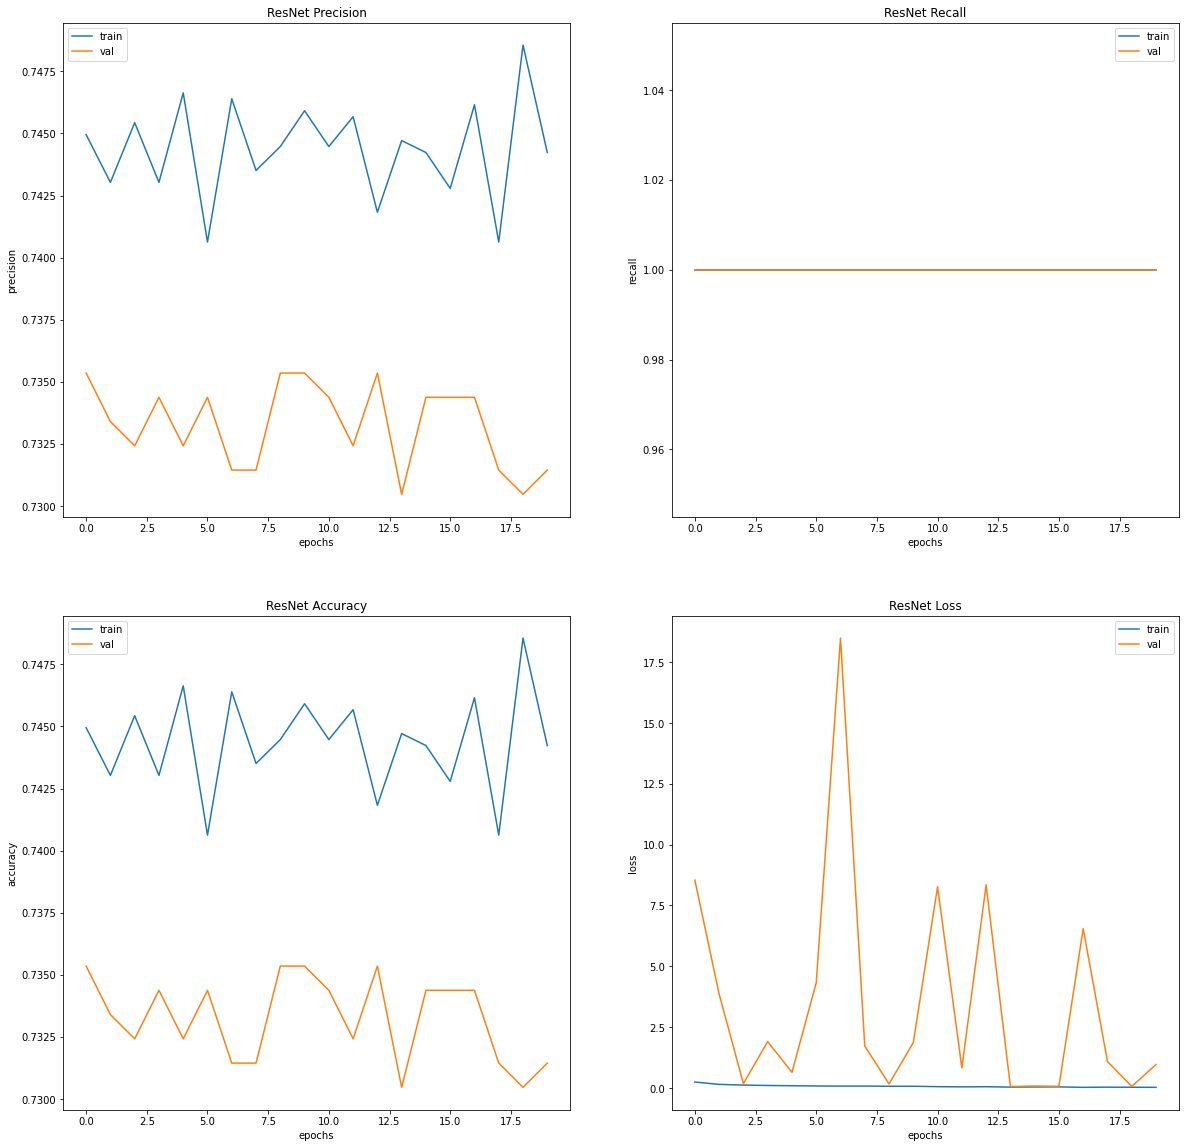

In [50]:
import matplotlib.pyplot as plt

# 결과 시각화 함수
def plot_metrics(history, title):
    fig, ax = plt.subplots(2, 2, figsize=(20, 20))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title(f'{title} {met.capitalize()}')
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

# CNN 모델 결과 시각화
plot_metrics(history_cnn, 'CNN')

# ResNet 모델 결과 시각화
plot_metrics(history_resnet, 'ResNet')

In [53]:
# CNN 모델 평가
loss_cnn, accuracy_cnn, precision_cnn, recall_cnn = cnn_model.evaluate(test_ds)
print(f'CNN Loss: {loss_cnn}, Accuracy: {accuracy_cnn}, Precision: {precision_cnn}, Recall: {recall_cnn}')

# ResNet 모델 평가
loss_resnet, accuracy_resnet, precision_resnet, recall_resnet = res_model.evaluate(test_ds)
print(f'ResNet Loss: {loss_resnet}, Accuracy: {accuracy_resnet}, Precision: {precision_resnet}, Recall: {recall_resnet}')

20/20 [==============================] - 4s 197ms/step - loss: 0.5293 - accuracy: 0.8606 - precision: 0.8315 - recall: 0.9744
CNN Loss: 0.5293205976486206, Accuracy: 0.8605769276618958, Precision: 0.8315098285675049, Recall: 0.9743589758872986
20/20 [==============================] - 4s 222ms/step - loss: 0.6562 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
ResNet Loss: 0.6562153697013855, Accuracy: 0.625, Precision: 0.625, Recall: 1.0


### Step 8. 중간 결과 분석

위의 학습 결과를 보면, CNN 모델은 비교적 좋은 성능을 보이는 반면, ResNet 모델의 성능이 상대적으로 낮게 나타나고 있습니다. 

이에 대한 몇 가지 가능한 원인을 살펴보겠습니다.

데이터 불균형:

ResNet 모델의 정밀도(precision)는 0.625, 재현율(recall)은 1.0입니다. 이는 모델이 대부분의 샘플을 폐렴으로 분류하고 있음을 나타냅니다. 데이터셋에 폐렴 케이스가 더 많을 경우, 모델이 모든 케이스를 폐렴으로 예측하는 경향이 생길 수 있습니다.
이 문제를 해결하기 위해 클래스 가중치(class weights)를 조정하거나 데이터 증강(augmentation)을 적용하여 불균형을 완화할 수 있습니다.

과적합 (Overfitting):

훈련 데이터에 모델이 과도하게 최적화되어 새로운 데이터에 대한 일반화 성능이 떨어질 수 있습니다.
과적합을 방지하기 위해 데이터 증강(augmentation), 드롭아웃(dropout), 조기 종료(early stopping) 등의 기법을 적용할 수 있습니다.

네트워크 아키텍처:

ResNet 모델의 구조가 주어진 문제에 적합하지 않을 수 있습니다. 예를 들어, 너무 차원수가 많다면, 오히려 성능을 저하시킬 수 있습니다.
모델의 깊이를 조절하거나, 다른 아키텍처를 실험해 볼 수 있습니다.

학습 파라미터:

학습률(learning rate), 배치 크기(batch size), 에포크 수(epochs) 등의 학습 파라미터가 최적화되지 않았을 수 있습니다.
학습 파라미터를 조정하여 모델의 성능을 개선할 수 있습니다.

### Step9. 새로운 조건으로 모델 학습 및 결과 확인

In [60]:
# 모델 훈련을 위한 파라미터
# EPOCHS = 10  # 에포크 수
# BATCH_SIZE = 32  # 배치 크기
# TRAIN_IMG_COUNT = len(train_ds)  # 훈련 이미지 수
# VAL_IMG_COUNT = len(val_ds)  # 검증 이미지 수

# CNN 모델 훈련 - augment 적용 안한 데이터
with tf.device('/GPU:0'):
    history_cnn_no_aug = cnn_model.fit(
        train_ds_no_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_no_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/20
130/130 [==============================] - 60s 402ms/step - loss: 0.0821 - accuracy: 0.9697 - precision: 0.9937 - recall: 0.9654 - val_loss: 0.9426 - val_accuracy: 0.7451 - val_precision: 1.0000 - val_recall: 0.6529
Epoch 2/20
130/130 [==============================] - 51s 394ms/step - loss: 0.0731 - accuracy: 0.9728 - precision: 0.9924 - recall: 0.9710 - val_loss: 0.0627 - val_accuracy: 0.9766 - val_precision: 0.9945 - val_recall: 0.9733
Epoch 3/20
130/130 [==============================] - 51s 394ms/step - loss: 0.0595 - accuracy: 0.9776 - precision: 0.9951 - recall: 0.9748 - val_loss: 0.0738 - val_accuracy: 0.9736 - val_precision: 0.9905 - val_recall: 0.9734
Epoch 4/20
130/130 [==============================] - 51s 396ms/step - loss: 0.0641 - accuracy: 0.9736 - precision: 0.9931 - recall: 0.9713 - val_loss: 0.0777 - val_accuracy: 0.9707 - val_precision: 0.9918 - val_recall: 0.9681
Epoch 5/20
130/130 [==============================] - 52s 404ms/step - loss: 0.0491 - accura

하필 20번째에서 accuracy값들이 val_recall값과 함께 폭락하였다.. 

In [61]:
# ResNet 모델 훈련 - augment 적용 안한 데이터
with tf.device('/GPU:0'):
    history_resnet_no_aug = res_model.fit(
        train_ds_no_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_no_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/20
130/130 [==============================] - 58s 390ms/step - loss: 0.0548 - accuracy: 0.7447 - precision: 0.7447 - recall: 1.0000 - val_loss: 0.5692 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 50s 383ms/step - loss: 0.0201 - accuracy: 0.7437 - precision: 0.7437 - recall: 1.0000 - val_loss: 0.0468 - val_accuracy: 0.7295 - val_precision: 0.7295 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 51s 392ms/step - loss: 0.0116 - accuracy: 0.7454 - precision: 0.7454 - recall: 1.0000 - val_loss: 2.4118 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 51s 398ms/step - loss: 0.0202 - accuracy: 0.7447 - precision: 0.7447 - recall: 1.0000 - val_loss: 0.0681 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 52s 400ms/step - loss: 0.0267 - accura

내가 만든 ResNet18은 일을 겁나 하기 싫어하나보다. 무조건 폐렴 진단 때리고 보나 recall값은 1인데 정확도가 앞선 CNN에 비해 여전히 안좋다.

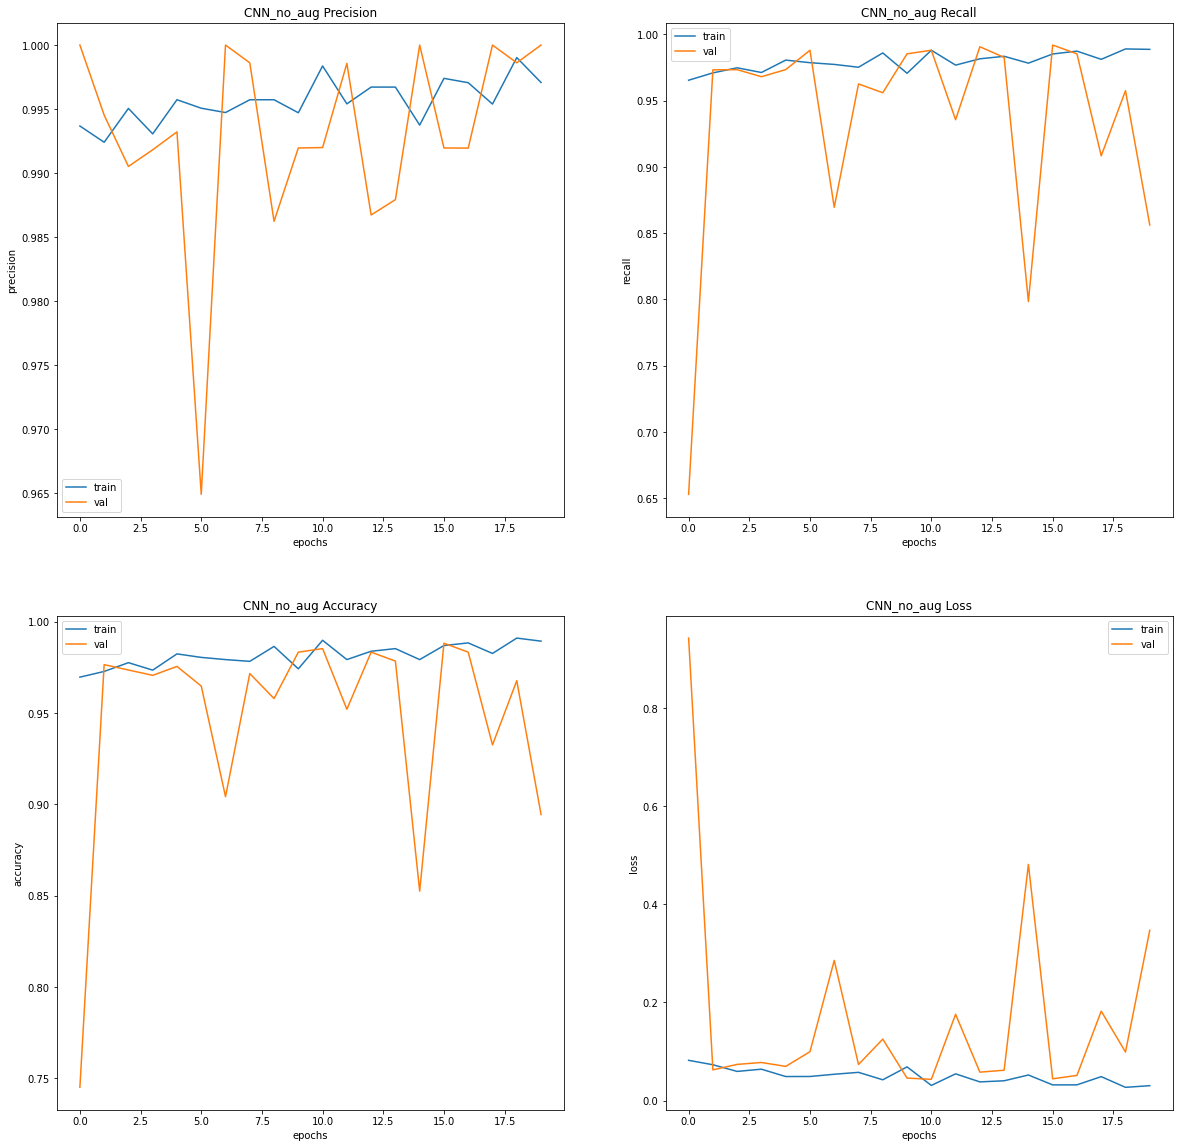

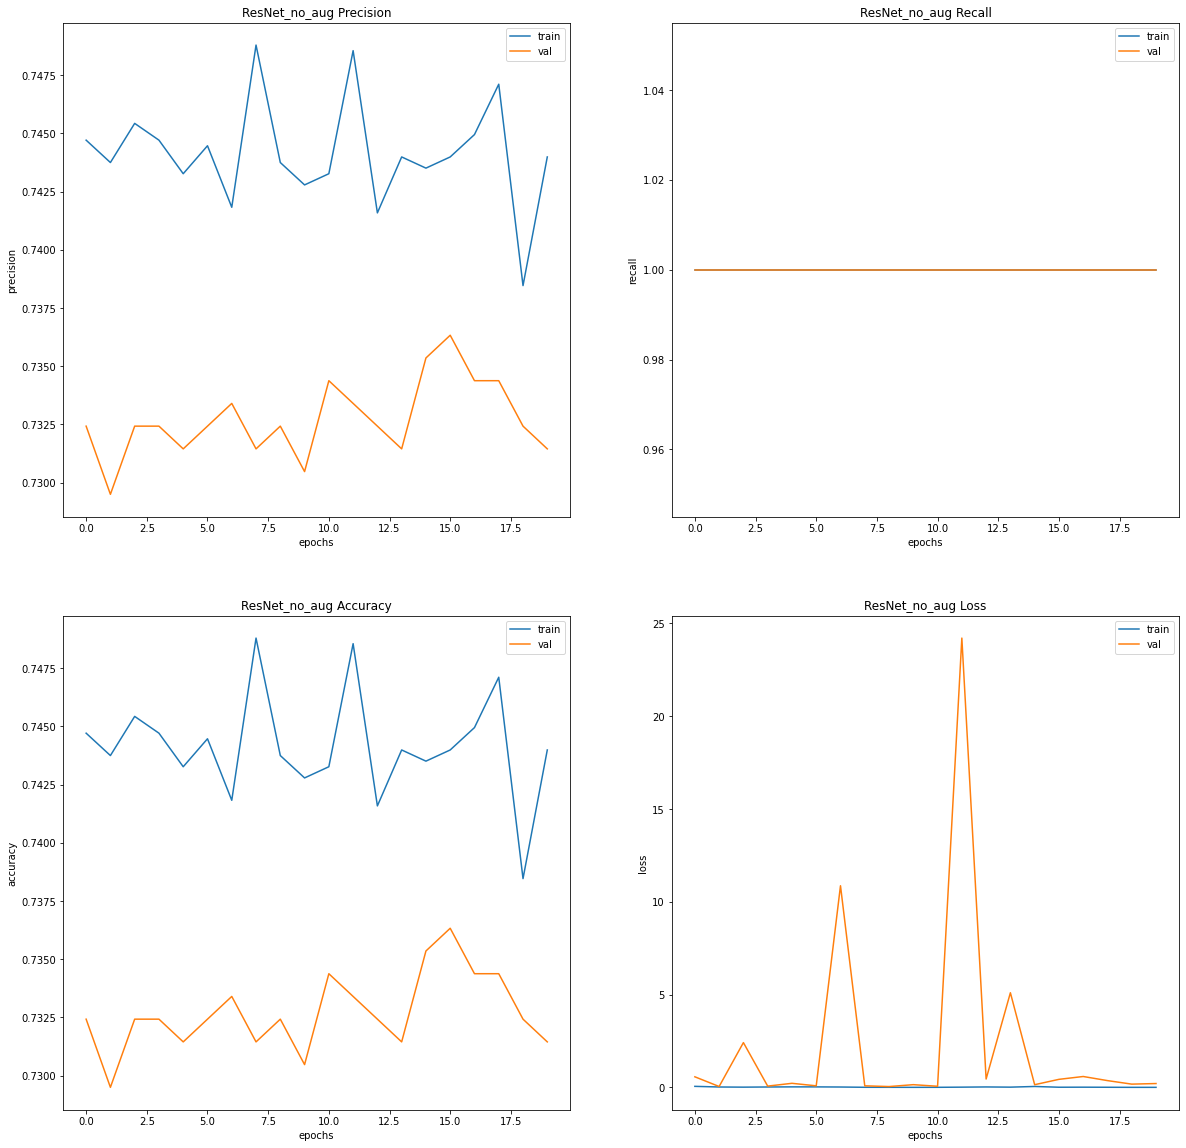

In [62]:
# 결과 시각화 함수
def plot_metrics(history, title):
    fig, ax = plt.subplots(2, 2, figsize=(20, 20))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title(f'{title} {met.capitalize()}')
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

# CNN 모델 결과 시각화
plot_metrics(history_cnn_no_aug, 'CNN_no_aug')

# ResNet 모델 결과 시각화
plot_metrics(history_resnet_no_aug, 'ResNet_no_aug')

In [63]:
# CNN 모델 평가
loss_cnn, accuracy_cnn, precision_cnn, recall_cnn = cnn_model.evaluate(test_ds_no_aug)
print(f'CNN Loss: {loss_cnn}, Accuracy: {accuracy_cnn}, Precision: {precision_cnn}, Recall: {recall_cnn}')

# ResNet 모델 평가
loss_resnet, accuracy_resnet, precision_resnet, recall_resnet = res_model.evaluate(test_ds_no_aug)
print(f'ResNet Loss: {loss_resnet}, Accuracy: {accuracy_resnet}, Precision: {precision_resnet}, Recall: {recall_resnet}')

20/20 [==============================] - 4s 221ms/step - loss: 0.4621 - accuracy: 0.8830 - precision: 0.8933 - recall: 0.9231
CNN Loss: 0.46207085251808167, Accuracy: 0.8830128312110901, Precision: 0.8933002352714539, Recall: 0.9230769276618958
20/20 [==============================] - 5s 219ms/step - loss: 1.0220 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
ResNet Loss: 1.0219621658325195, Accuracy: 0.625, Precision: 0.625, Recall: 1.0


### Step10. 폐렴 진단 학습 모델 결과 보고서

1. **개요 (Introduction)**:

   - 이 프로젝트는 폐 사진을 보고 폐렴 여부를 감별하는 딥러닝 모델을 만드는 것을 목표로 하고 있습니다.
   - 위 프로젝트의 목표는 의사들의 예진을 도와 업무의 효율성을 높이고, 환자와 의사 모두에게 일의 피로도를 줄여주는 것을 목표로 하고 있습니다.
   - 위 프로젝트에서 사용한 모델은 CNN과 ResNet18 모델을 사용하였으며, 데이터 증강(augmentation) 적용 여부에 따른 성능 변화를 분석합니다.  <br>
<br>
2. **목차 (Table of Contents)**:

   - 위의 프로젝트는 전체 10단계의 Step으로 이루어져 있으며, 실험환경을 구성하고, 데이터를 준비하며, 전치리를 거쳐, 모델을 만들고, 여러 상황들에 대한 실험을 반복하는 단계로 이루어져 있습니다.
   
       목차.
       
        1. 실험 환경 구성 - 
        2. 데이터 준비하기 -
        3. 데이터 시각화 -
        4. CNN과 ResNet-18 모델 구현 -
        5. 데이터 imbalance 처리 -
        6. 모델 훈련 -
        7. 결과 확인과 시각화 - 
        8. 중간 결과 분석 -
        9. 새로운 조건으로 훈련 및 결과 확인 -
        10. 결과 보고서 - <br>
<br>
3. **주석 및 의견 (Comments and Opinions)**:

   - 모델 구현 및 훈련: CNN과 ResNet-18 모델을 구현하고, augmentation의 적용 여부에 따라 두 모델을 각각 훈련시켰습니다.
   
   - 성능 평가: 두 모델 모두 초기 목표에 근접한 성능을 보였으나, ResNet-18 모델은 특히 높은 recall 값을 보였습니다.
   
   - 데이터 불균형 처리: 클래스 가중치를 사용하여 폐렴과 정상 이미지 간의 불균형을 처리했습니다.  
<br>
4. **요약 (Summary)**:

   - CNN 모델은 비교적 높은 정확도를 보였으나, ResNet-18 모델은 recall 값이 1.0에 도달하면서 정확도가 다소 낮게 나타났습니다.
   
   - 데이터 불균형이 모델 성능에 영향을 미치는 주요 요소 중 하나라고 판단되었습니다.
   
   - Augmentation 적용 여부에 따른 성능 차이가 확인되었으며, ResNet18 모델의 경우 Augmentation 적용 하지 않은 데이터 셋에서 훨씬 낮은 loss값을 확인 할 수 있었습니다.  
<br> 
5. **회고 (Reflection)**:

   - 프로젝트를 통해 딥러닝 모델의 성능에 영향을 미치는 다양한 요소들에 대한 이해를 높일 수 있었습니다.
   - 모델의 성능이 어느 지점에서 향상되지 않고 정체 되어있는 구간이 있는데, 이를 해결하지 못한 부분이 아쉬움으로 남습니다.
   - 데이터 증강이 오히려 모델 성능을 저하시키는 요인이 될수 있음과, 데이터 불균형에 대해 생각해 보게 되었습니다.
   - 다음에는 좀 더 세분화된 목표를 가지고 다양한 시도를 해보아야 겠다고 생각했습니다.  <br>


6. **참고문헌 (References)**:

   - [보건 복지부, 대한 의학회에서 제공한 의료 영상 자료](https://health.kdca.go.kr/healthinfo/biz/health/gnrlzHealthInfo/gnrlzHealthInfo/gnrlzHealthInfoView.do?cntnts_sn=5493) 
   - [서울대학교병원에서 이야기하는 의료 인공지능에 대한 영상](https://youtu.be/2eG5jIcz3f8)
   - [위키피디아 - 해부학용어](https://ko.wikipedia.org/wiki/%ED%95%B4%EB%B6%80%ED%95%99_%EC%9A%A9%EC%96%B4)
   - [위키피디아 - 폐렴](https://ko.wikipedia.org/wiki/%ED%8F%90%EB%A0%B4)
   - [케글 노트북 - 실습코드](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)
   - [[기계 학습]. SGD 와 mini batch ( 최적화 기법 )](https://acdongpgm.tistory.com/202)
   - [CNN, Convolutional Neural Network](http://taewan.kim/post/cnn/)
   - [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)
   - [Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)
   - [딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)
   

이러한 구조는 체계적이고 전문적인 보고서를 작성하는 데 도움이 됩니다. 보고서의 성격에 따라 일부 섹션은 생략되거나 다른 섹션이 추가될 수 있습니다.

평가문항

1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.	

    상세기준 : 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
    

2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.

    상세기준 : regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
    

3. ResNet 모델을 구현 하였다.

    상세기준 : Resnet 의 Residual block을 구현하고 학습의 경우 1에폭만 진행하여도 인정
